<a href="https://colab.research.google.com/github/dorota10/ML_UEP_2024/blob/CaseStudy2/CaseStudy2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [3]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
movies['genres'] = movies['genres'].str.split('|')
movies = movies.explode('genres')

films_scifi=len(movies[movies["genres"]=="Sci-Fi"])
print(f"W bazie znajduje się {films_scifi} filmów Sci-Fi.")

W bazie znajduje się 980 filmów Sci-Fi.


In [38]:
# movies_rates=pd.DataFrame(ratings.groupby("movieId")["rating"].mean())
movies_rates=pd.merge(movies[["movieId", "title", 'genres']], ratings[['movieId', 'rating']], left_on="movieId", right_on="movieId")

movies_names = movies_rates[["movieId", "title"]].drop_duplicates()
movies_names[['title', 'year']] = movies_names['title'].str.split(' \(', n=1, expand=True)
movies_names['year'] = movies_names['year'].str.rstrip(')')

#Tworzę dwa słowniki

#pierwszy słownik pozwala wyszukać id na podstawie tytułu (bez roku)
movies_dict= {row['title']: row['movieId'] for _, row in movies_names.iterrows()}
#drugi słownik pozwala wyszukać film na podstawie id
id_dict= {row['movieId']: row['title'] for _, row in movies_names.iterrows()}

In [19]:
comedy_rates=movies_rates[movies_rates["genres"]=="Comedy"][["rating"]]
comedy_rates

,rating
645,4.0
646,4.0
647,4.5
648,2.5
649,4.5
...,...
274461,3.5
274465,4.0
274471,4.0
274474,3.5


<ipython-input-20-b30ebbda5d6e>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(comedy_rates,x="rating", palette="magma")


<Axes: xlabel='rating', ylabel='count'>

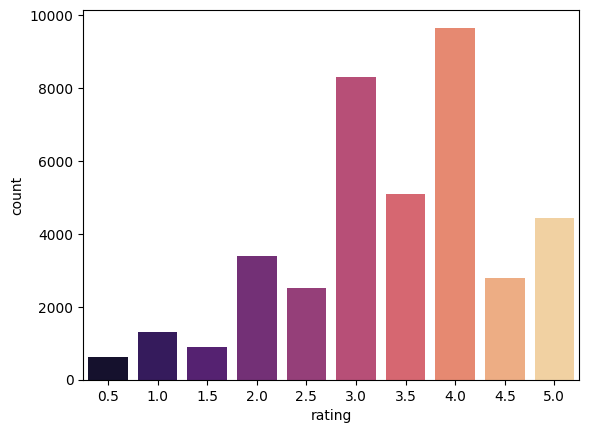

In [20]:
sns.countplot(comedy_rates,x="rating", palette="magma")

In [9]:
action_rates=movies_rates[movies_rates["genres"]=="Action"]["rating"]
action_mean=round(action_rates.mean(),2)
print(f"Średnia ocena wszystkich filmów akcji wynosi {action_mean}.")

Średnia ocena wszystkich filmów akcji wynosi 3.45.


In [10]:
movies_rates[['movieId',	'title']]

,movieId,title
0,1,Toy Story (1995)
1,1,Toy Story (1995)
2,1,Toy Story (1995)
3,1,Toy Story (1995)
4,1,Toy Story (1995)
...,...,...
274475,193583,No Game No Life: Zero (2017)
274476,193585,Flint (2017)
274477,193587,Bungo Stray Dogs: Dead Apple (2018)
274478,193587,Bungo Stray Dogs: Dead Apple (2018)


In [11]:
action_movies=movies_rates[movies_rates["genres"]=="Action"]
action_stats=action_movies.groupby(['movieId', 'title'])['rating'].agg(["count", "mean"])
C = action_stats['count'].mean()
m = action_stats['mean'].mean()
def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

bayesian_avg_ratings = action_movies.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
action_stats_with_bayes = action_stats.merge(bayesian_avg_ratings, on='movieId')
action_stats_with_bayes=movies_rates[['movieId',	'title']].merge(action_stats_with_bayes, on='movieId').drop_duplicates()
action_stats_with_bayes.sort_values(by="bayesian_avg", ascending=False, inplace=True)
best_three=list(action_stats_with_bayes["title"][:3])
print(f"Najlepsze filmy akcji wg średniej bayesowskiej to \n 1. {best_three[0]}, \n 2. {best_three[1]} \n 3. {best_three[2]} ")

Najlepsze filmy akcji wg średniej bayesowskiej to 
 1. Fight Club (1999), 
 2. Star Wars: Episode IV - A New Hope (1977) 
 3. Star Wars: Episode V - The Empire Strikes Back (1980) 


In [12]:
action_stats_with_bayes

,movieId,title,count,mean,bayesian_avg
47700,2959,Fight Club (1999),218,4.272936,4.188811
6139,260,Star Wars: Episode IV - A New Hope (1977),251,4.231076,4.159938
22189,1196,Star Wars: Episode V - The Empire Strikes Back...,211,4.215640,4.133145
42200,2571,"Matrix, The (1999)",278,4.192446,4.130021
84662,58559,"Dark Knight, The (2008)",149,4.238255,4.122617
...,...,...,...,...,...
44463,2643,Superman IV: The Quest for Peace (1987),16,1.687500,2.407294
30930,1499,Anaconda (1997),27,1.925926,2.373467
35062,1882,Godzilla (1998),33,1.954545,2.338482
51982,3593,Battlefield Earth (2000),19,1.657895,2.331176


In [14]:
pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162979 sha256=bb01f4bad71f17707d5ad34a64cd80910a9225d923d8743438c84881068c80e9
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [21]:
from surprise import Dataset, Reader
from surprise.model_selection import GridSearchCV, cross_validate
from surprise import SVD, KNNWithMeans
from surprise.prediction_algorithms import SVD, KNNBasic, KNNBaseline
from surprise.prediction_algorithms.knns import KNNWithMeans

In [22]:
min_rating = ratings.rating.min()
max_rating = ratings.rating.max()

reader = Reader(rating_scale=(min_rating, max_rating))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [23]:
algo = SVD()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True);

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8765  0.8729  0.8774  0.8651  0.8822  0.8748  0.0057  
MAE (testset)     0.6741  0.6725  0.6740  0.6649  0.6759  0.6722  0.0038  
Fit time          1.37    1.40    1.37    1.38    1.58    1.42    0.08    
Test time         0.12    0.11    0.11    0.11    0.19    0.13    0.03    


In [64]:
param_grid_knn_means = {'k': [2, 3, 4, 5, 6]}

knn_with_means = KNNWithMeans(sim_options={'name': 'pearson', 'user_based': False})

cv_knn_means = cross_validate(knn_with_means, data, measures=['RMSE'], cv=5, n_jobs=-1)

results_knn = pd.DataFrame({'k': param_grid_knn_means['k'], 'RMSE': cv_knn_means['test_rmse']})



In [27]:
results_knn.mean()

k       4.000000
RMSE    0.904277
dtype: float64

In [28]:
import plotly.graph_objs as go
import plotly.io as pio

# Tworzenie śladu (trace) dla wykresu liniowego
trace = go.Scatter(x=results_knn['k'], y=results_knn['RMSE'], mode='lines+markers')

# Tworzenie układu (layout) dla wykresu
layout = go.Layout(title='RMSE vs. k',
                   xaxis=dict(title='k'),
                   yaxis=dict(title='RMSE'))

# Tworzenie figury
fig = go.Figure(data=[trace], layout=layout)

# Wyświetlanie wykresu
pio.show(fig)

Najleszpa liczba sąsiadów to k=4

In [75]:
trainset = data.build_full_trainset()
knn_with_means.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [83]:
chosen_title="Jumanji"

chosen_movie_id= movies_dict[chosen_title]

# Uzyskanie identyfikatora wewnętrznego dla filmu "Jumanji"
movie_inner_id = knn_with_means.trainset.to_inner_iid(chosen_movie_id)

# Uzyskanie rekomendacji dla filmu "Jumanji" (identyfikator wewnętrzny)
movie_neighbors = knn_with_means.get_neighbors(movie_inner_id, k=6)

# Konwersja identyfikatorów wewnętrznych na identyfikatory zewnętrzne (nazwy filmów)
movie_neighbors_raw_ids = [knn_with_means.trainset.to_raw_iid(movie_inner_id) for movie_inner_id in movie_neighbors]

# Wydrukowanie rekomendacji
print(f"Rekomendowane filmy dla filmu {chosen_title}:")
for movie_id in movie_neighbors_raw_ids:
    print(id_dict[movie_id])

Rekomendowane filmy dla filmu Jumanji:
Return to Oz
Transformers: The Movie
Buffalo '66
Boys from Brazil, The
Before Night Falls
Eye for an Eye


In [84]:
chosen_title="Flint"

chosen_movie_id= movies_dict[chosen_title]

# Uzyskanie identyfikatora wewnętrznego dla filmu "Flint"
movie_inner_id = knn_with_means.trainset.to_inner_iid(chosen_movie_id)

# Uzyskanie rekomendacji dla filmu "Flint" (identyfikator wewnętrzny)
movie_neighbors = knn_with_means.get_neighbors(movie_inner_id, k=6)

# Konwersja identyfikatorów wewnętrznych na identyfikatory zewnętrzne (nazwy filmów)
movie_neighbors_raw_ids = [knn_with_means.trainset.to_raw_iid(movie_inner_id) for movie_inner_id in movie_neighbors]

# Wydrukowanie rekomendacji
print(f"Rekomendowane filmy dla filmu {chosen_title}:")
for movie_id in movie_neighbors_raw_ids:
    print(id_dict[movie_id])

Rekomendowane filmy dla filmu Flint:
Toy Story
Grumpier Old Men
Heat
Seven
Usual Suspects, The
From Dusk Till Dawn


### Porównanie z metodą z zajęć

In [52]:
def create_sparse(df):
    M = df['userId'].nunique()
    N = df['movieId'].nunique()
    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]
    X = csr_matrix((df["rating"], (user_index, item_index)), shape=(M,N))
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [53]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper=create_sparse(ratings)

In [54]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz #scipy.sparse.csr_matrix.nnz no of stored values, including explicit 0
sparsity = n_ratings/n_total
sparsity_p = round(sparsity*100, 2)
print(f"Matrix sparsity: {sparsity_p} %")

Matrix sparsity: 1.7 %


In [55]:
n_ratings_per_user = X.getnnz(axis=1)

In [56]:
def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    X = X.T
    neighbour_ids = []
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    k=k+1
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [86]:
movies_dict["Flint"]

193585

In [89]:
is_similar=find_similar_movies(193585, X, movie_mapper, movie_inv_mapper, 10, metric='cosine')
movies[movies["movieId"].isin(is_similar)]["title"].unique()

array(['Fullmetal Alchemist: The Sacred Star of Milos (2011)',
       'The Stanford Prison Experiment (2015)', 'Bakuman (2015)',
       'Kizumonogatari Part 1: Tekketsu (2016)', 'The Thinning (2016)',
       'The Night Is Short, Walk on Girl (2017)', 'Ferdinand (2017)',
       'Too Funny to Fail: The Life and Death of The Dana Carvey Show (2017)',
       'The Clapper (2018)', 'Fullmetal Alchemist 2018 (2017)'],
      dtype=object)